Balance a recurrent neural network

In [7]:
import numpy as onp
from jax import numpy as np
from jax import random, vmap, jit, value_and_grad
from jax.lax import scan, clamp
from jax.ops import index_min, index_update
from jax.numpy import clip
import jax
from jax.experimental.optimizers import adam

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_palette("colorblind")
sns.set_context("poster")

In [8]:
slope = 10
@jax.custom_transforms
def spiking_fn(x):
    return np.where(x>0, 1.0, 0.0)

jax.defvjp(spiking_fn, lambda g, ans, x: g / (slope * np.abs(x) + 1.0)**2)

In [9]:
def split_keys(key, n_keys):
    new_keys = random.split(key, n_keys+1)
    return (k for k in new_keys[1:])

def random_parameters(key, Ne, Ni, p = 0.2):
    keys = split_keys(key, 2 * 4)
    weights = {'Wee': random.normal(next(keys), (Ne, Ne)) * 1/np.sqrt(Ne * p), 
            'Wie': random.normal(next(keys), (Ni, Ne)) * 1 / np.sqrt(Ni * p),
           'Wei': random.normal(next(keys), (Ne, Ni)) * 1 / np.sqrt(Ni * p),
           'Wii': random.normal(next(keys), (Ni, Ni)) * 1 / np.sqrt(Ni * p)}
    masks = {}
    for key, weight in weights.items():
        masks[key] = random.bernoulli(next(keys), p, weight.shape)
    return weights, masks

In [10]:
def gen_init_states(Ne, Ni):
    ve = np.zeros((Ne, ), dtype='float32')
    vi = np.zeros((Ni, ), dtype='float32')
    se = np.zeros((Ne, ), dtype='float32')
    si = np.zeros((Ni, ), dtype='float32')
    tspikee = np.ones((Ne, ), dtype='float32') * -np.inf
    tspikei = np.ones((Ni, ), dtype='float32') * -np.inf
    syne = np.ones((Ne, ), dtype='float32') # Filtered spike trains
    syni = np.ones((Ni, ), dtype='float32')# Filtered spike trains
    syne_slow = np.ones((Ne, ), dtype='float32') # Filtered spike trains
    t = 0
    return se, si, ve, vi, tspikee, tspikei, syne, syni, syne_slow, t

def step_forward(params, masks, states, xt):
    se, si, ve, vi, tspikee, tspikei, syne, syni, syne_slow, t = states
    p = {'vth': 1.0, 'tau_syn': 5.0, 'tau': 10.0 ,
         'tau_std': 20.0, 'trst': 5.0}
    dt = 1.0
    
    Wee = np.abs(params['Wee']) * masks['Wee']
    Wei = np.abs(params['Wei']) * masks['Wei'] * -1
    Wie = np.abs(params['Wie']) * masks['Wie']
    Wii = np.abs(params['Wii']) * masks['Wii'] * -1

    
    se = spiking_fn(ve - p['vth'])
    si = spiking_fn(vi - p['vth'])
    tspikee = np.where(se == 1.0, t, tspikee)
    tspikei = np.where(si == 1.0, t, tspikei)
    
  
    syne = (1 - dt / p['tau_syn']) * syne + se 
    syni = (1 - dt / p['tau_syn']) * syni + si
    syne_slow = (1 - dt / p['tau_std']) * syne + se
    
    dvdt = -ve / p['tau'] + np.dot(Wee, syne) + np.dot(Wei, syni)  
    ve = np.where(t - tspikee <= 5.0, 0.0, ve + dt * dvdt + 1)
    dvdt = -vi / p['tau'] + np.dot(Wie, syne) + np.dot(Wii, syni)
    vi = np.where(t - tspikei <= 5.0, 0.0, vi + dt * dvdt)
    
    
    states = se, si, ve, vi, tspikee, tspikei, syne, syni, syne_slow, t+1
    
    return states, states

def network(params, masks, x = np.zeros((1000, ))):
    init_states = gen_init_states(Ne, Ni)
    _, states = scan(lambda s, x: step_forward(params, masks, s, x), init_states, x)
    return states


def loss_fn(y, y_hat):
    return np.mean((y - y_hat)**2)

def update_params(step, get_params, opt_update, opt_state, masks):
    params = get_params(opt_state)
    
    def loss_fn(params, masks):
        states = network(params, masks)
        syne_slow = states[-2]
        return np.mean((syne_slow - 0.2)**2)
    
    l, grads = value_and_grad(loss_fn)(params, masks)
    return l, opt_update(step, grads, opt_state)

network_jit = jit(network)
update_params_jit = jit(update_params, (1,2,4))#, (1, 2, 4))

In [11]:
Ne, Ni = 400, 100
seed = onp.random.randint(1e6)
key = random.PRNGKey(seed)
params, masks = random_parameters(key, Ne, Ni)
states = network_jit(params, masks)
ve = states[0]
spikes_e = states[0]
print(spikes_e.sum())
se, si, ve, vi, tspikee, tspikei, syne, syni, syne_slow, t = states

57164.0


In [12]:
opt_init, opt_update, get_params = adam(5e-3)
params, masks = random_parameters(key, Ne, Ni)
opt_state = opt_init(params)

n_steps = 100
for step in range(n_steps):
    l, opt_state = update_params_jit(step, get_params, opt_update, opt_state, masks)
    if step%10 == 0:
        # Eval
        params = get_params(opt_state)
        states = network_jit(params, masks)
        se, si, ve, vi, tspikee, tspikei, syne, syni, syne_slow, t = states
        print(step, l, syne_slow.mean(), int(se.mean(1).sum()))

0 0.7496524 0.8213385 142
10 0.11648629 0.10365678 17
20 0.081601 0.065613076 10
30 0.08067299 0.060973108 9
40 0.07415617 0.053113896 8
50 0.07008844 0.048112005 7
60 0.068627164 0.04702424 7
70 0.06785508 0.04553108 7
80 0.06531409 0.042709537 6
90 0.06575904 0.04174918 6


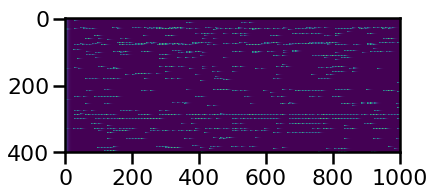

In [13]:
plt.imshow(syne.T)

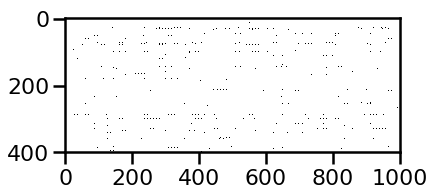

In [14]:
plt.imshow(se.T, cmap='gray_r')

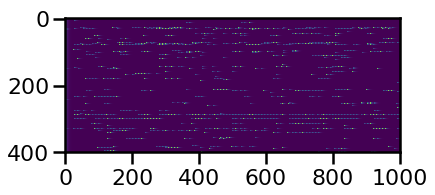

In [15]:
plt.imshow(syne_slow.T)